# imports

# UiB paths
%run /Home/siv30/wad005/master/GRB/src/paths/uib.ipynb
#%run /Users/andreas/phys/master/GRB/src/paths/mac.ipynb

%run /Home/siv30/wad005/master/GRB/src/read_matlab_file.ipynb
%run /Home/siv30/wad005/master/GRB/src/LC_calibration.ipynb

In [1]:
# Mac paths
%run /Users/andreas/phys/master/GRB/src/read_matlab_file.ipynb
%run /Users/andreas/phys/master/GRB/src/LC_calibration.ipynb

All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
safety_time.ipynb loaded successfully!
LC_calibration loaded successfully!


In [41]:
import astropy as ap
from stingray import Lightcurve as LC
from stingray import CrossCorrelation
from dateutil import parser



## TODO
    -Stingray seems to be a good API for creating EventList object and writing that to a pha and bak file for ASIM
    -Need left most edges in bins_keV for EventList.from_list()
    


## Notes
    -Assuming 
    -bins_keV are the right most edges! 
    -Anders have filtered for keV >=500 
    -Implementation is ok. Proceed to wrapping a function around it.
    --> have a shift variable as input (have to do with lining up the LC from the different spacecrafts)
    
    
## Problems

    

# ToF

In [3]:
#time of flight from KW to ASIM. Given in seconds
ToF = {"GRB180720":-4.2377,"GRB181222":2.8716, "GRB190206":4.9225, "GRB190305":3.4460,
      "GRB190606":4.0316,"GRB200415":4.1840,"GRB200521":-0.6226,"GRB200716":3.0155,
      "GRB201227":0.7142, "GRB210424":-0.5033, "GRB210619":-2.6183}

In [4]:
def ToF_correction(grb_id=None):
    ToF_us = ToF[grb_id]*1e6
    df,T0 = complete_df(grb_id=grb_id)
    df["tus"], T0_calibrated = df["tus"] - ToF_us, T0 - timedelta(microseconds=ToF_us) #calibrating 
    return df,T0,T0_calibrated

# Functions for prepping ASIM data for XSPEC

### bin control

In [5]:
df_bin = pd.read_csv(bin_edges_path + "HED_binedges.txt")
df_bin.head()

,energy_bin_start_keV,energy_bin_stop_keV
0,10.00000,12.58925
1,12.58925,15.84893
2,15.84893,19.95262
3,19.95262,25.11886
4,25.11886,31.62278


fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,3))

ax1.plot((df_bin["energy_bin_start_keV"]))
ax2.plot(np.log(df_bin["energy_bin_start_keV"]))
ax1.set_xlabel("bin number")
ax1.set_ylabel("keV bin")
ax2.set_xlabel("bin number")
ax2.set_ylabel("ln(keV)")
plt.show()

start = df_bin["energy_bin_start_keV"].to_numpy()
#start = np.append(0,start)
end = df_bin["energy_bin_stop_keV"].to_numpy()
bins_keV=np.append(start,end[-1])
print(len(bins_keV))
bins_keV

df_hist_check = pd.read_csv(bin_edges_path + "HED_(0.8 ms to 3.2 ms).txt")
print("Num hist counts totoal: ", sum(df_hist_check["counts"].to_numpy()[1:]))
print("bins_keV are the right most edge")

df_hist_check.tail()

### keV bin function

In [31]:
def keV_hist(df=None,t_start=None, duration=None, time_interval=None,keV_interval=None,keV_bins=None):
    '''
    TODO: Make sure this function is working correctly. Critical for validity of ASIM data
    
    
    NOTE: working with ms resolution for the tus array.
    LED detector sensitive from 20-400 keV
    HED detector sensitive from 200 to >20MeV
    
    input: 
    ---------------------------------------
    note: All times are relative to T0 in the df
    
    df <pd.dataframe>: complete dataframe with no flagged events
    t_start <float>: (optional). Given in ms. If specified, duration must also be set.'
    duration <float>: Must be provided in (ms). Could be computed from time_interval
    time_interval <tuple>:  start and end (ms) of the time interval for the keV binning.
    keV_interval <tuple> default is None. Meaning the whole spectrum
    
    
    return: <pd.dataframe> with the bin_counts and bin_edges as a dataframe
    '''
    df.sort_values(by=['tus'],inplace=True) #first sorting by tus in increasing order
    
    
    #tus handling-------------------------------------------
    tus_arr = df["tus"].to_numpy()
    tus_arr = tus_arr/1e3 #converting to ms resolution

    
    #if t_start==None:
    #    tus_start,tus_end = min(tus_arr),max(tus_arr)
    #    idx_start, idx_end = find_nearest(tus_arr,tus_start), find_nearest(tus_arr,tus_end)+1 #including the last trigger
    if time_interval != None:
        idx_start, idx_end = find_nearest(tus_arr,time_interval[0]), find_nearest(tus_arr,time_interval[1])+1
        if duration == None:
            duration = (time_interval[1]-time_interval[0])/1e3 #converting back to seconds because we need that in the dataframe
            print("duration not given. Computed duration is :", np.round(duration,3), " ms")
    else:
        if duration==None and t_start!=None:
            return print("duration must be specified if time interval is not set")
        else:
            tus_start,tus_end = t_start,t_start+duration #selecting the interval
            idx_start, idx_end = find_nearest(tus_arr,tus_start), find_nearest(tus_arr,tus_end)+1 #including the nearest trigger
    

    tus_arr = tus_arr[idx_start:idx_end] #selecting the interval for tus
    
    #keV handling-------------------------------------------
    keV_arr = df["keV"].to_numpy()
    keV_arr = keV_arr[idx_start:idx_end] #selecting keV's on the given tus interval
    
    if keV_interval==None:
         return print("keV bounds must be specified")
    elif keV_interval == "max":
        keV_lower, keV_upper = 1e1, 1e5
        print("Computing whole spectrum (10-1e5 keV)")
    else: 
        keV_lower,keV_upper = keV_interval[0],keV_interval[1] #selecting the bounds for the keV's

    ii = []
    for i,keV in enumerate(keV_arr): #finding
        if keV_lower<=keV<=keV_upper:
            ii.append(i)
    
    #Selecting the triggers that are within the time & energy bounds
    tus_keV_bound = tus_arr[ii]
    keV_bound = keV_arr[ii]
    
    #histogramming-----------------------------------------
    #Just using the left bins + the last upper for binning
    if keV_bins == None:
        df_bin = pd.read_csv(bin_edges_path + "HED_binedges.txt")
        print("keV bins are set for HED")
        keV_bin_start = df_bin["energy_bin_start_keV"].to_numpy()
        #start = np.append(0,start)
        keV_bin_end = df_bin["energy_bin_stop_keV"].to_numpy()
        keV_bins = np.append(keV_bin_start,keV_bin_end[-1]) #just appending the last bin

    
    hist_keV, edges_keV = np.histogram(keV_bound,bins=keV_bins)
    
    
    #Check this block of code for errors!
    poisson_arr = np.sqrt(hist_keV) #handle this one. might be some negative numbers in it?
    if hist_keV[0] == 0:
        hist_keV = np.append(-9999.0,hist_keV)
        poisson_arr = np.append(-9999.0,poisson_arr)
    duration_arr = np.append(-9999.0,(([np.round(duration,3)])*(len(hist_keV)-1))) #should not be hardcoded like this ??
    df_keV = pd.DataFrame({"bins_keV":edges_keV, "counts":hist_keV, 
                           "poisson_error_counts":poisson_arr, "duration_seconds":duration_arr}) #ERROR different lengths!
    print("Energies binned!")
    return df_keV

### Cross Corrolate function

In [53]:
#notes: KW bins are given in seconds --> Converting tus_ASIM to seconds 

def cross_corrolate(tus_ASIM=None, kw_filename=None, binsize=None):
    """
    TODO: Change the function to operate with seconds instead
    
    cross corrolation function between ASIM and KW. Function will itself bin the photon array and return the desired t_shift lag to shift the data into KW or ASIM ref frame.
    Subtract t_shift from KW lc to bring it into the ASIM ref frame.
    Add t_shift to ASIM lc to bring it into KW ref frame.
    
    Best to use 16ms KW file for cross corrolation. This is because the 2ms binning window is short ~ 1 s
    Note: Only the bins specified by binsize will be used in KW data
    
    input:
    --------------------------------------
    tus_ASIM <np.array>: tus array
    kw_filename <str>: filename.
    binsize <float>: given in seconds
    
    return:
    --------------------------------------
    t_shift <float>: given in us. Rounded to 6 sig figures """
    

    #KW handling------------------------------------------------------------------------------
    if str(int(binsize*1e3)) != kw_filename[kw_filename.find('_')+1:-6]:
        return print('filename and binsize is not correct')
    
    kw_file = kw_lc_path + kw_filename
    kw_df = pd.read_csv(kw_file,sep='\s+')
    kw_bin_lo, kw_bin_hi, G3 = kw_df["Ti"].to_numpy(), kw_df["Tf"].to_numpy(), kw_df["G3"].to_numpy()
    kw_dt = np.round(np.diff(kw_bin_lo),3)
    i_stop_kw = np.where(kw_dt>binsize)[0][0]
    kw_bin_lo, kw_bin_hi, G3 = kw_bin_lo[:i_stop_kw], kw_bin_right[:i_stop_kw], G3[:i_stop_kw]
    kw_lc = LC(time=kw_bin_lo + binsize/2, counts=G3,skip_checks=True,dt=binsize)
    check_alignment = [np.all(np.round(kw_lc.bin_lo,3) == kw_bin_lo),
                       np.all(np.round(kw_lc.bin_hi,3) == kw_bin_hi), 
                       np.all(np.round(kw_lc.counts,3) == G3)]
    for i, bool_ in enumerate(check_alignment):
        if bool_ == False:
            print(i)
            if i == 0:
                 print("bin_lo not aligned")
            elif i == 1:
                 print("bin_hi not aligned")
            elif i == 2:
                 print("counts not aligned")
                    
    #ASIM handling ---------------------------
    tus_ASIM = tus_ASIM/1e6 #converting to seconds
    kw_first_t, kw_last_t = find_nearest(tus_ASIM,kw_bin_lo[0]), find_nearest(tus_ASIM,kw_bin_hi[-1])
    tus_ASIM = tus_ASIM[kw_first_t:kw_last_t]
    asim_lc = LC.make_lightcurve(toa=tus_ASIM,dt = binsize)
    
    # CC and tshift --------------------------
    CC = CrossCorrelation(kw_lc,asim_lc,mode="full")
    t_shift = np.round(CC.cal_timeshift(dt=binsize)[0],6)*1e6
    asim_lc_shifted = asim_lc.shift(CC.time_shift)
    
    #Plotting ---------------------------------
    kw_lc.plot(title="KW lc")
    asim_lc.plot(title="ASIM lc")
    asim_lc_shifted.plot(title="ASIM lc shifted")
    CC.plot(labels = ['Time Lags (seconds)','Correlation'])
    
    print("tshift (s) ", t_shift/1e6)
    print("tshift returned as us")
    return t_shift

### General steps to prepare data for xspec
    1) get complete_df with flags removed
    2) shift tus array in dataframe by tshift provided by cross_corrolate()
    3) use keV_bin() for binning of the energies
    4) change format of dataframe with this command: pd.set_option('display.float_format', '{:.6E}'.format)
    5) export to txt file with command: np.savetxt(r'/Users/andreas/phys/master/GRB/spectral_analysis/GRB190206A_keV_histogram.txt"',df_keV.values, delimiter=',', header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')



from astropy.table import Table
df = pd.read_csv("/Users/andreas/phys/master/GRB/spectral_analysis/keV_histograms/GRB180720")
t = Table.from_pandas(df)
t.write('GRB180720_new.fits')

# Exporting ASIM data

### GRB210619B

In [38]:
df_ASIM, T0_ASIM = complete_df(grb_id="GRB210619",remove_flag=True)
print(T0_ASIM)
df_ASIM.sort_values(by=["tus"],inplace=True)
df_ASIM.head()

Creating df for long GRB
Absolute time correction subtracted from T0
75 valleys removed
Absolute time correction subtracted from T0
76 valleys removed
Absolute time correction subtracted from T0
59 valleys removed
Absolute time correction subtracted from T0
59 valleys removed
Absolute time correction subtracted from T0
75 valleys removed
Absolute time correction subtracted from T0
65 valleys removed
Absolute time correction subtracted from T0
75 valleys removed
Absolute time correction subtracted from T0
56 valleys removed
Absolute time correction subtracted from T0
49 valleys removed
Absolute time correction subtracted from T0
75 valleys removed
found one cutting index ... 
found one cutting index ... 
found one cutting index ... 
subseq not found in next array ... keeping whole array
found one cutting index ... 
found one cutting index ... 
found one cutting index ... 
found one cutting index ... 
found one cutting index ... 
GRB concatenated ...
erg converted to keV
df sorted by adr

,tus,erg,typ,adr,dau,det,keV,cal_abc,st,dt,flag
0,-4.254044E+05,34,0,8,3,2,9.730633E+02,"-0.006382, 29.5333, -23.6913",9.461266E-01,NaN,False
1,-4.251982E+05,67,0,6,2,3,7.831964E+02,"0.004273, 10.7282, 45.22555",3.831964E+00,NaN,False
2,-4.250907E+05,2037,0,10,4,1,3.730037E+04,"0.002586, 13.017, 54.4738",3.236119E+01,NaN,False
3,-4.250906E+05,1571,0,11,4,2,2.946823E+04,"0.002877, 14.2272, 16.74477",2.300000E+01,NaN,False
4,-4.250906E+05,1595,0,6,2,3,2.802732E+04,"0.004273, 10.7282, 45.22555",2.300000E+01,1.076111E+02,False


In [39]:
tus_A = df_ASIM["tus"].to_numpy()
binsize = 0.016 # 2 ms binsize
kw_filename = 'GRB210619B_16ms.txt'

#-448000.0 us tshift for 16ms bin
#-730000 us tshift for 2ms binning. Problem: KW lc is only 1 s long for 2ms binning

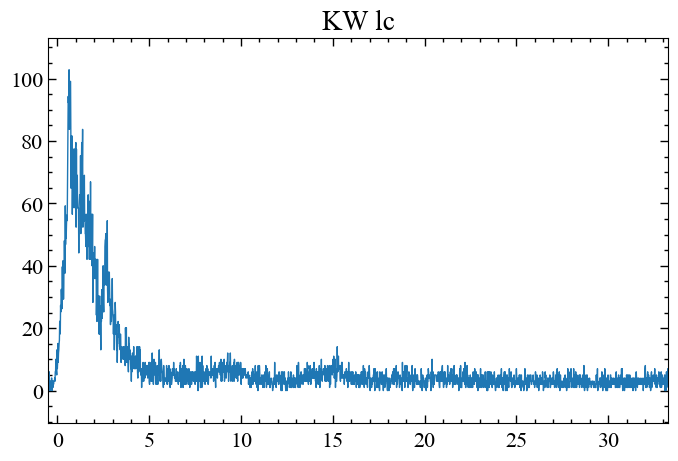

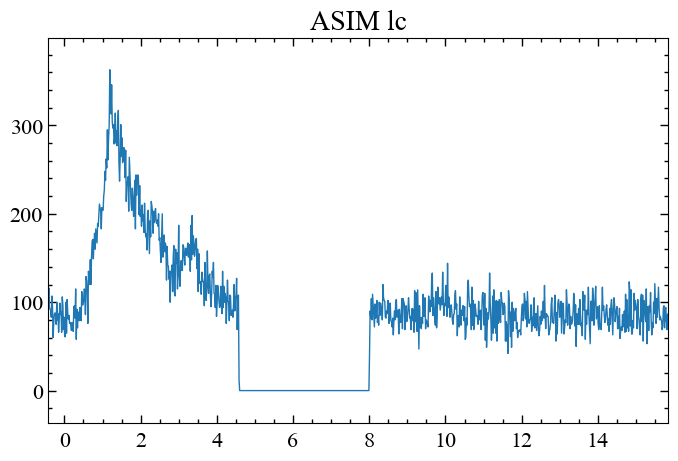

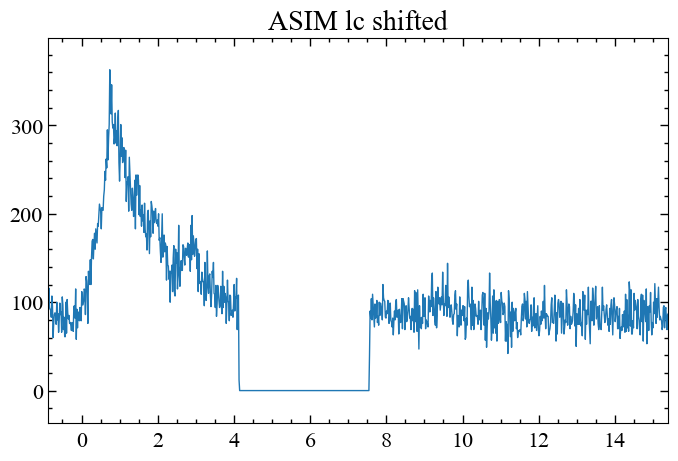

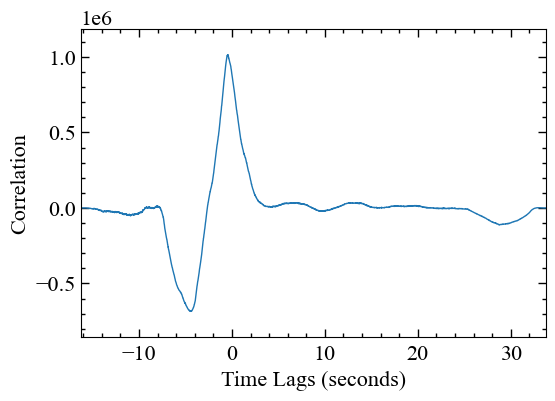

tshift (s)  -0.448


In [46]:
tshift = cross_corrolate(tus_ASIM=tus_A,binsize=binsize,kw_filename=kw_filename)

In [16]:
tus_shift = tus_A + tshift
df_ASIM["tus"] = tus_shift
df_ASIM.head()

,tus,erg,typ,adr,dau,det,keV,cal_abc,st,dt,flag
0,-873404.361111,34,0,8,3,2,973.063308,"-0.006382, 29.5333, -23.6913",0.946127,NaN,False
1,-873198.194444,67,0,6,2,3,783.196447,"0.004273, 10.7282, 45.22555",3.831964,NaN,False
2,-873090.666667,2037,0,10,4,1,37300.371034,"0.002586, 13.017, 54.4738",32.361187,NaN,False
3,-873090.611111,1571,0,11,4,2,29468.229927,"0.002877, 14.2272, 16.74477",23.000000,NaN,False
4,-873090.583333,1595,0,6,2,3,28027.323375,"0.004273, 10.7282, 45.22555",23.000000,107.611111,False


In [34]:
df_ASIM, T0_ASIM = complete_df(grb_id="GRB210619",remove_flag=True)
keV_df = keV_hist(df=df_ASIM,time_interval=(1.0*1e3,1.7*1e3),duration=0.7,keV_interval="max")

Creating df for long GRB
Absolute time correction subtracted from T0
75 valleys removed
Absolute time correction subtracted from T0
76 valleys removed
Absolute time correction subtracted from T0
59 valleys removed
Absolute time correction subtracted from T0
59 valleys removed
Absolute time correction subtracted from T0
75 valleys removed
Absolute time correction subtracted from T0
65 valleys removed
Absolute time correction subtracted from T0
75 valleys removed
Absolute time correction subtracted from T0
56 valleys removed
Absolute time correction subtracted from T0
49 valleys removed
Absolute time correction subtracted from T0
75 valleys removed
found one cutting index ... 
found one cutting index ... 
found one cutting index ... 
subseq not found in next array ... keeping whole array
found one cutting index ... 
found one cutting index ... 
found one cutting index ... 
found one cutting index ... 
found one cutting index ... 
GRB concatenated ...
erg converted to keV
df sorted by adr

In [36]:
pd.set_option('display.float_format', '{:.6E}'.format)
keV_df

,bins_keV,counts,poisson_error_counts,duration_seconds
0,1.000000E+01,-9.999000E+03,-9.999000E+03,-9.999000E+03
1,1.258925E+01,0.000000E+00,0.000000E+00,7.000000E-01
2,1.584893E+01,0.000000E+00,0.000000E+00,7.000000E-01
3,1.995262E+01,0.000000E+00,0.000000E+00,7.000000E-01
4,2.511886E+01,0.000000E+00,0.000000E+00,7.000000E-01
5,3.162278E+01,0.000000E+00,0.000000E+00,7.000000E-01
6,3.981072E+01,0.000000E+00,0.000000E+00,7.000000E-01
7,5.011872E+01,0.000000E+00,0.000000E+00,7.000000E-01
8,6.309573E+01,0.000000E+00,0.000000E+00,7.000000E-01
9,7.943282E+01,0.000000E+00,0.000000E+00,7.000000E-01


### GRB201227A
    -Have KW spectra for this burst
    -Have FERMI spectra for this burst
    -Need ASIM spectra ...
    
    
    -Using KW ref frame ...
        -tshift_FERMI = 
        -tshift_ASIM = 
        
    -Time range in KW_ref frame: T0_KW = 0 to T0_KW+0.064s